In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson, chisquare

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.mode.chained_assignment = None 

def generate_seasons(start_year, end_year):
    seasons = []
    for year in range(start_year, end_year):
        start = str(year)[-2:]
        end = str(year + 1)[-2:]
        seasons.append(start + end)
    return seasons

seasons = generate_seasons(2005, 2024)

df_ls = []

for season in seasons:
    df = pd.read_csv(f'https://www.football-data.co.uk/mmz4281/{season}/E0.csv')
    try:
        df["Date"] = pd.to_datetime(df["Date"],format="%d/%m/%y")
    except ValueError:
        df["Date"] = pd.to_datetime(df["Date"],format="%d/%m/%Y")
    df_ls.append(df)

main_df = pd.concat(df_ls)

In [69]:
main_df = main_df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
main_df['TotalGoals'] = main_df['FTHG'] + main_df['FTAG']

,Date,HomeTeam,AwayTeam,FTHG,FTAG,TotalGoals
0,15/08/09,Aston Villa,Wigan,0.0,2.0,2.0
1,15/08/09,Blackburn,Man City,0.0,2.0,2.0
2,15/08/09,Bolton,Sunderland,0.0,1.0,1.0
3,15/08/09,Chelsea,Hull,2.0,1.0,3.0
4,15/08/09,Everton,Arsenal,1.0,6.0,7.0
...,...,...,...,...,...,...
253,24/02/2024,Man United,Fulham,1.0,2.0,3.0
254,24/02/2024,Bournemouth,Man City,0.0,1.0,1.0
255,24/02/2024,Arsenal,Newcastle,4.0,1.0,5.0
256,25/02/2024,Wolves,Sheffield United,1.0,0.0,1.0


In [77]:
mean_goals = main_df['TotalGoals'].mean()
max_goals = main_df['TotalGoals'].max()
goal_range = np.arange(0, max_goals+1)

poisson_probabilities = poisson.pmf(goal_range, mean_goals)

In [78]:
mean_goals

2.778594478307637

In [76]:
max_goals

10.0

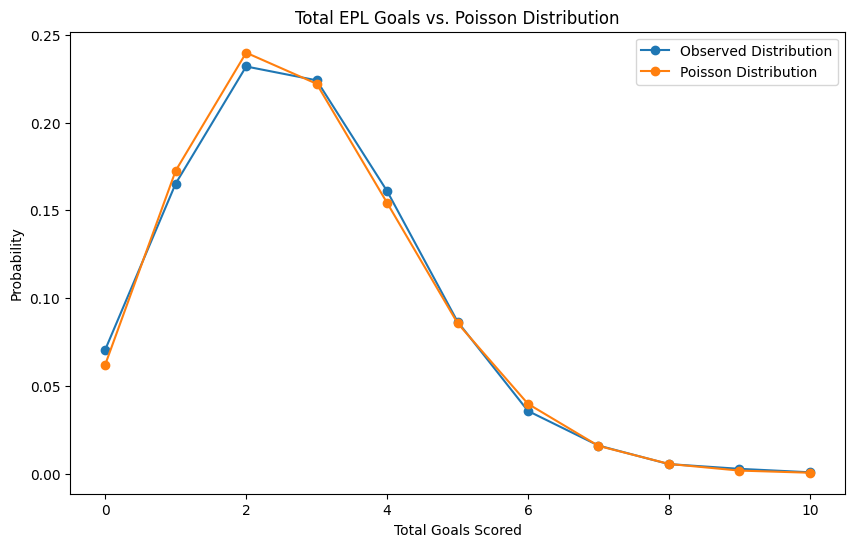

In [71]:
observed_frequencies = main_df['TotalGoals'].value_counts().sort_index()
observed_probabilities = observed_frequencies / observed_frequencies.sum()

# Ensure all possible goals are represented (0 to max_goals), filling missing values with 0
observed_probabilities = observed_probabilities.reindex(goal_range, fill_value=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(observed_probabilities.index, observed_probabilities, 'o-', label='Observed Distribution')
plt.plot(goal_range, poisson_probabilities, 'o-', label='Poisson Distribution')
plt.xlabel('Total Goals Scored')
plt.ylabel('Probability')
plt.title('Total EPL Goals vs. Poisson Distribution')
plt.legend()
plt.show()

In [72]:
def poisson_goal_probabilities(mean_goals, max_goals):
    probabilities = {}
    for goals in range(max_goals + 1):
        probability = poisson.pmf(goals, mean_goals)
        probabilities[goals] = probability
    return probabilities


mean_goals = 3
max_goals = 10
probabilities = poisson_goal_probabilities(mean_goals, max_goals)

for goals, prob in probabilities.items():
    print(f"Probability of {goals} goals: {prob:.4f}")

Probability of 0 goals: 0.0498
Probability of 1 goals: 0.1494
Probability of 2 goals: 0.2240
Probability of 3 goals: 0.2240
Probability of 4 goals: 0.1680
Probability of 5 goals: 0.1008
Probability of 6 goals: 0.0504
Probability of 7 goals: 0.0216
Probability of 8 goals: 0.0081
Probability of 9 goals: 0.0027
Probability of 10 goals: 0.0008
